Reloading Tuner from my_dir\bidirectional_lstm_tuning\tuner0.json
Epoch 1/50


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  1/179 ━━━━━━━━━━━━━━━━━━━━ 18:44 6s/step - loss: 0.0354

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 0.0064 - val_loss: 0.0242
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0026 - val_loss: 0.0150
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0015 - val_loss: 0.0077
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0014 - val_loss: 0.0068
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0010 - val_loss: 0.0059
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0010 - val_loss: 0.0067
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 9.1805e-04 - val_loss: 0.0048
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 38m

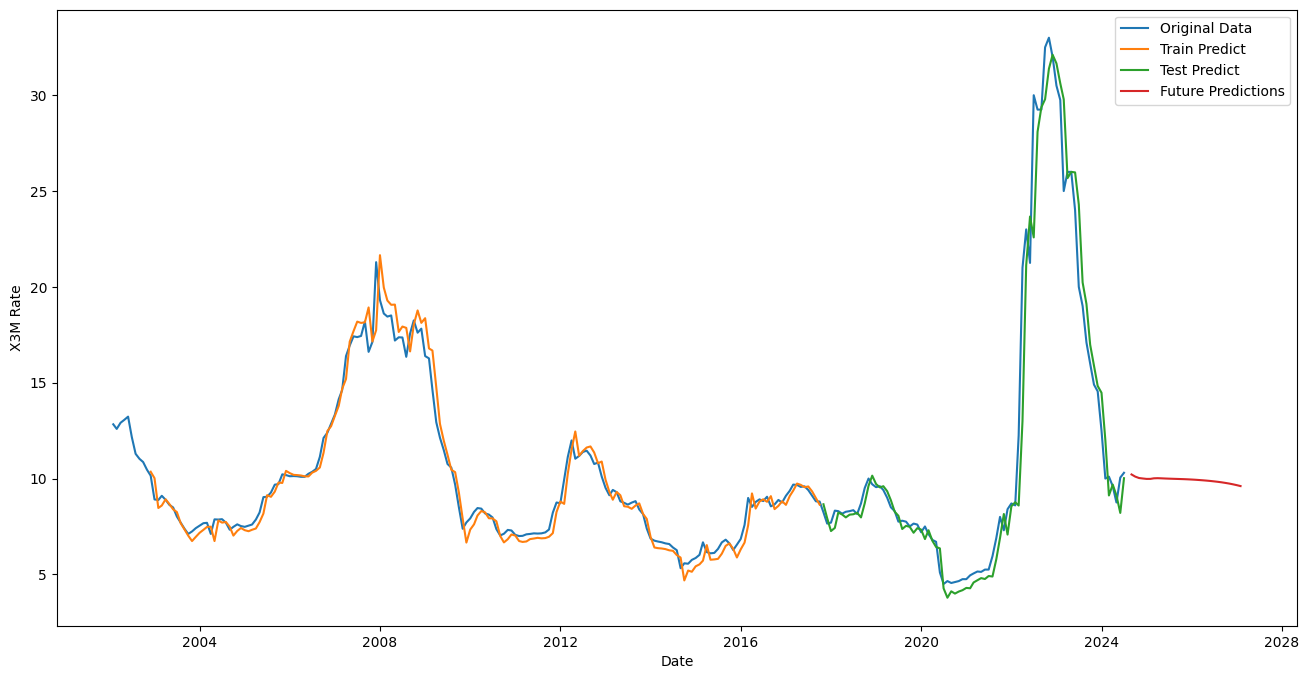

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import keras_tuner as kt

# Load your data
data = pd.read_csv('Sri Lanka 3-Month Bond Yield Historical Data .csv')
data = data.iloc[::-1].reset_index(drop=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Price']]  # Select the X3M column
data = data.dropna()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the time step
time_step = 10

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - time_step:]

# Create the TimeseriesGenerator for training and testing data
train_generator = TimeseriesGenerator(train_data, train_data, length=time_step, batch_size=1)
test_generator = TimeseriesGenerator(test_data, test_data, length=time_step, batch_size=1)

# Define the model-building function with Bidirectional LSTM
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=True,
        input_shape=(time_step, 1)
    )))
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Bidirectional(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=False
    )))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=4,
    executions_per_trial=1,
    directory='my_dir',
    project_name='bidirectional_lstm_tuning'
)

# Run the tuner
tuner.search(train_generator, epochs=50, validation_data=test_generator)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

# Make predictions for the training and testing data
train_predict = model.predict(train_generator)
test_predict = model.predict(test_generator)

# Inverse transform the predictions to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the y_train and y_test to get actual values
y_train = scaler.inverse_transform(train_data[time_step:])
y_test = scaler.inverse_transform(test_data[time_step:])

# Function to predict future interest rates
def predict_future(model, data, time_step, future_steps):
    predictions = []
    last_sequence = data[-time_step:]
    
    for _ in range(future_steps):
        # Prepare the input data
        input_data = last_sequence.reshape((1, time_step, 1))
        
        # Predict the next value
        predicted_value = model.predict(input_data)
        
        # Store the predicted value
        predictions.append(predicted_value[0, 0])
        
        # Update the last_sequence
        last_sequence = np.append(last_sequence[1:], predicted_value, axis=0)
    
    return predictions

# Predict future interest rates for the next 12 months (or any desired future period)
future_steps = 30
future_predictions = predict_future(model, scaled_data, time_step, future_steps)

# Inverse transform the future predictions to get actual values
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Prepare the data for plotting
train_predict_index = range(time_step, time_step + len(train_predict))
test_predict_index = range(len(train_predict) + (time_step * 2) + 1, len(scaled_data) - 1)
future_dates = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='M')[1:]
future_data = pd.DataFrame(future_predictions, index=future_dates, columns=['Future Predictions'])

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(data.index[train_predict_index], train_predict, label='Train Predict')
plt.plot(data.index[-len(test_predict):], test_predict, label='Test Predict')
plt.plot(future_data.index, future_data, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('X3M Rate')
plt.legend()
plt.show()


In [3]:
future_dates

DatetimeIndex(['2024-08-31', '2024-09-30', '2024-10-31', '2024-11-30',
               '2024-12-31', '2025-01-31', '2025-02-28', '2025-03-31',
               '2025-04-30', '2025-05-31', '2025-06-30', '2025-07-31',
               '2025-08-31', '2025-09-30', '2025-10-31', '2025-11-30',
               '2025-12-31', '2026-01-31', '2026-02-28', '2026-03-31',
               '2026-04-30', '2026-05-31', '2026-06-30', '2026-07-31',
               '2026-08-31', '2026-09-30', '2026-10-31', '2026-11-30',
               '2026-12-31', '2027-01-31'],
              dtype='datetime64[ns]', freq='M')

In [4]:
future_data

,Future Predictions
2024-08-31,10.213169
2024-09-30,10.101041
2024-10-31,10.026847
2024-11-30,10.002924
2024-12-31,9.981153
2025-01-31,9.982138
2025-02-28,10.011951
2025-03-31,10.018991
2025-04-30,10.011237
2025-05-31,10.001848


In [5]:
from sklearn.metrics import mean_squared_error

In [7]:
mse=mean_squared_error(y_test,test_predict)
mse

2.917512776198686

In [8]:
rmse=np.sqrt(mse)
rmse

1.7080728252035058

In [10]:
model.save('bidiectionalLSTM.h5')